In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
image = cv2.imread("Images/tableFor3cropped.jpg")
#half = cv2.resize(image, (0, 0), fx = 0.5, fy = 0.5)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
imgCanny = cv2.Canny(gray,150,50)
blur = cv2.GaussianBlur(gray, (7, 7), 1)
imgCannyBlur = cv2.Canny(blur,150,50)


In [ ]:
half = cv2.resize(image, (0, 0), fx = 0.5, fy = 0.5)
plt.figure(figsize = (12,16))
plt.imshow(cv2.cvtColor(half, cv2.COLOR_BGR2GRAY) , cmap='gray', aspect='equal')

In [5]:
_, threshold = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY) 
contours, _ = cv2.findContours( 
    threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 


In [ ]:
def getContours(image, orig):
    contours,hierarchy = cv2.findContours(image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        print(area)
        if area > 500:
            cv2.drawContours(orig, cnt, -1, (255, 0, 0), 3)
            peri = cv2.arcLength(cnt,True)
            #print(peri)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)
            print(len(approx))
            objCor = len(approx)
            x, y, w, h = cv2.boundingRect(approx)
            if objCor ==3: 
                objectType ="Tri"
            elif objCor == 4:
                aspRatio = w / float(h)
                if aspRatio > 0.98 and aspRatio < 1.03: objectType= "Square"
                else:objectType = "Rectangle"
            elif objCor > 4: objectType = "Circles"
            else: objectType = "None"

            cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(orig,objectType,
                        (x+(w//2)-10,y+(h//2)-10),cv2.FONT_HERSHEY_COMPLEX,0.7,
                        (0,0,0),2)

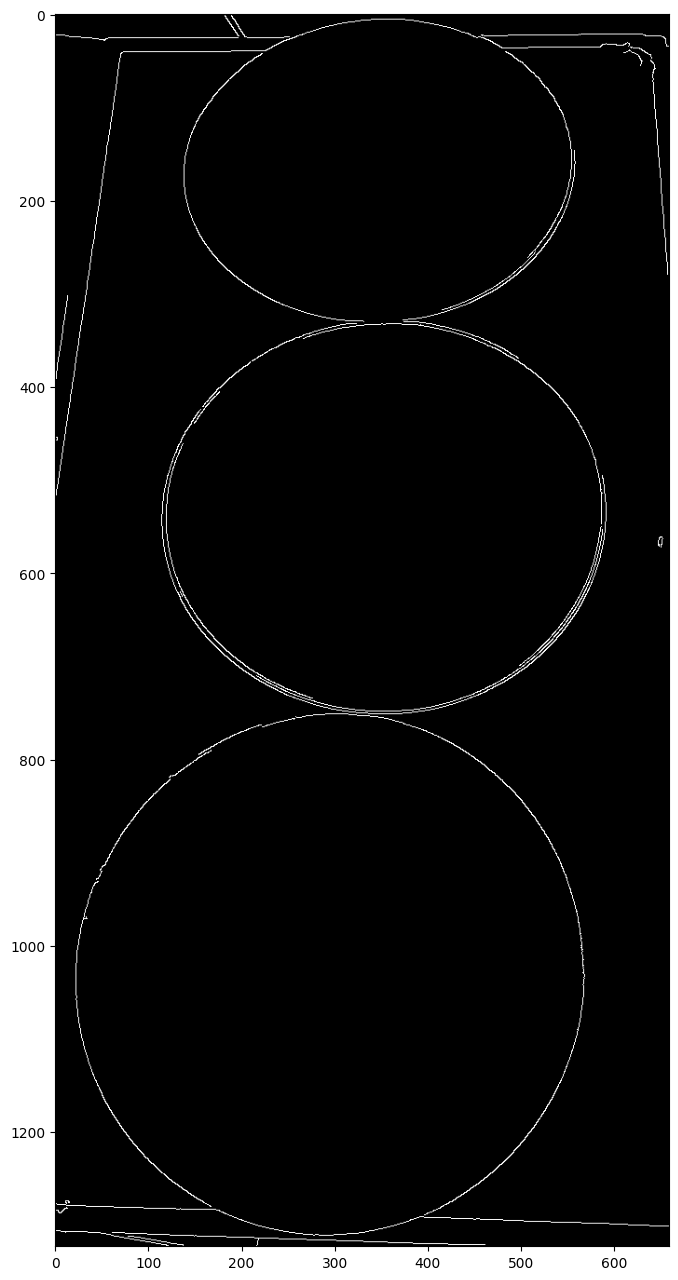

In [12]:
plt.figure(figsize = (12,16))
plt.imshow(imgCannyBlur, cmap='gra y', aspect='equal')

In [ ]:
thresholded = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

In [13]:
contours, heirarchy = cv2.findContours(imgCannyBlur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [14]:
img_cont = image.copy()
cv2.drawContours(img_cont, contours, -1, (0, 255, 0), 2)
cv2.imshow("Image", img_cont)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
def on_trackbar_change(v):
    _, threshold = cv2.threshold(gray, 151, 255, cv2.THRESH_BINARY) 
    canny = cv2.Canny(threshold,v,T2)
    
    contours, heirarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_cont = image.copy()
    cv2.drawContours(img_cont, contours, -1, (0, 255, 0), 2)
    cv2.imshow(title_window, img_cont)

def empty(val):
    pass


def on_thresh_change(v):
    _, threshold = cv2.threshold(gray, v, 255, cv2.THRESH_BINARY) 
    cv2.imshow(title_window, threshold)


T1, T2 = 100, 100
thresh = 130

title_window = "dinnerTable"
cv2.namedWindow(title_window)
cv2.createTrackbar("canny T1", title_window , 100, 500, on_trackbar_change)
# cv2.createTrackbar("canny T2", title_window , 100, 500, empty)
cv2.createTrackbar("threshold", title_window , 0, 255, on_thresh_change)


on_trackbar_change(T1)
cv2.waitKey(0)



-1

In [5]:
_, threshold = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY) 
cv2.imshow(title_window, threshold)

: 

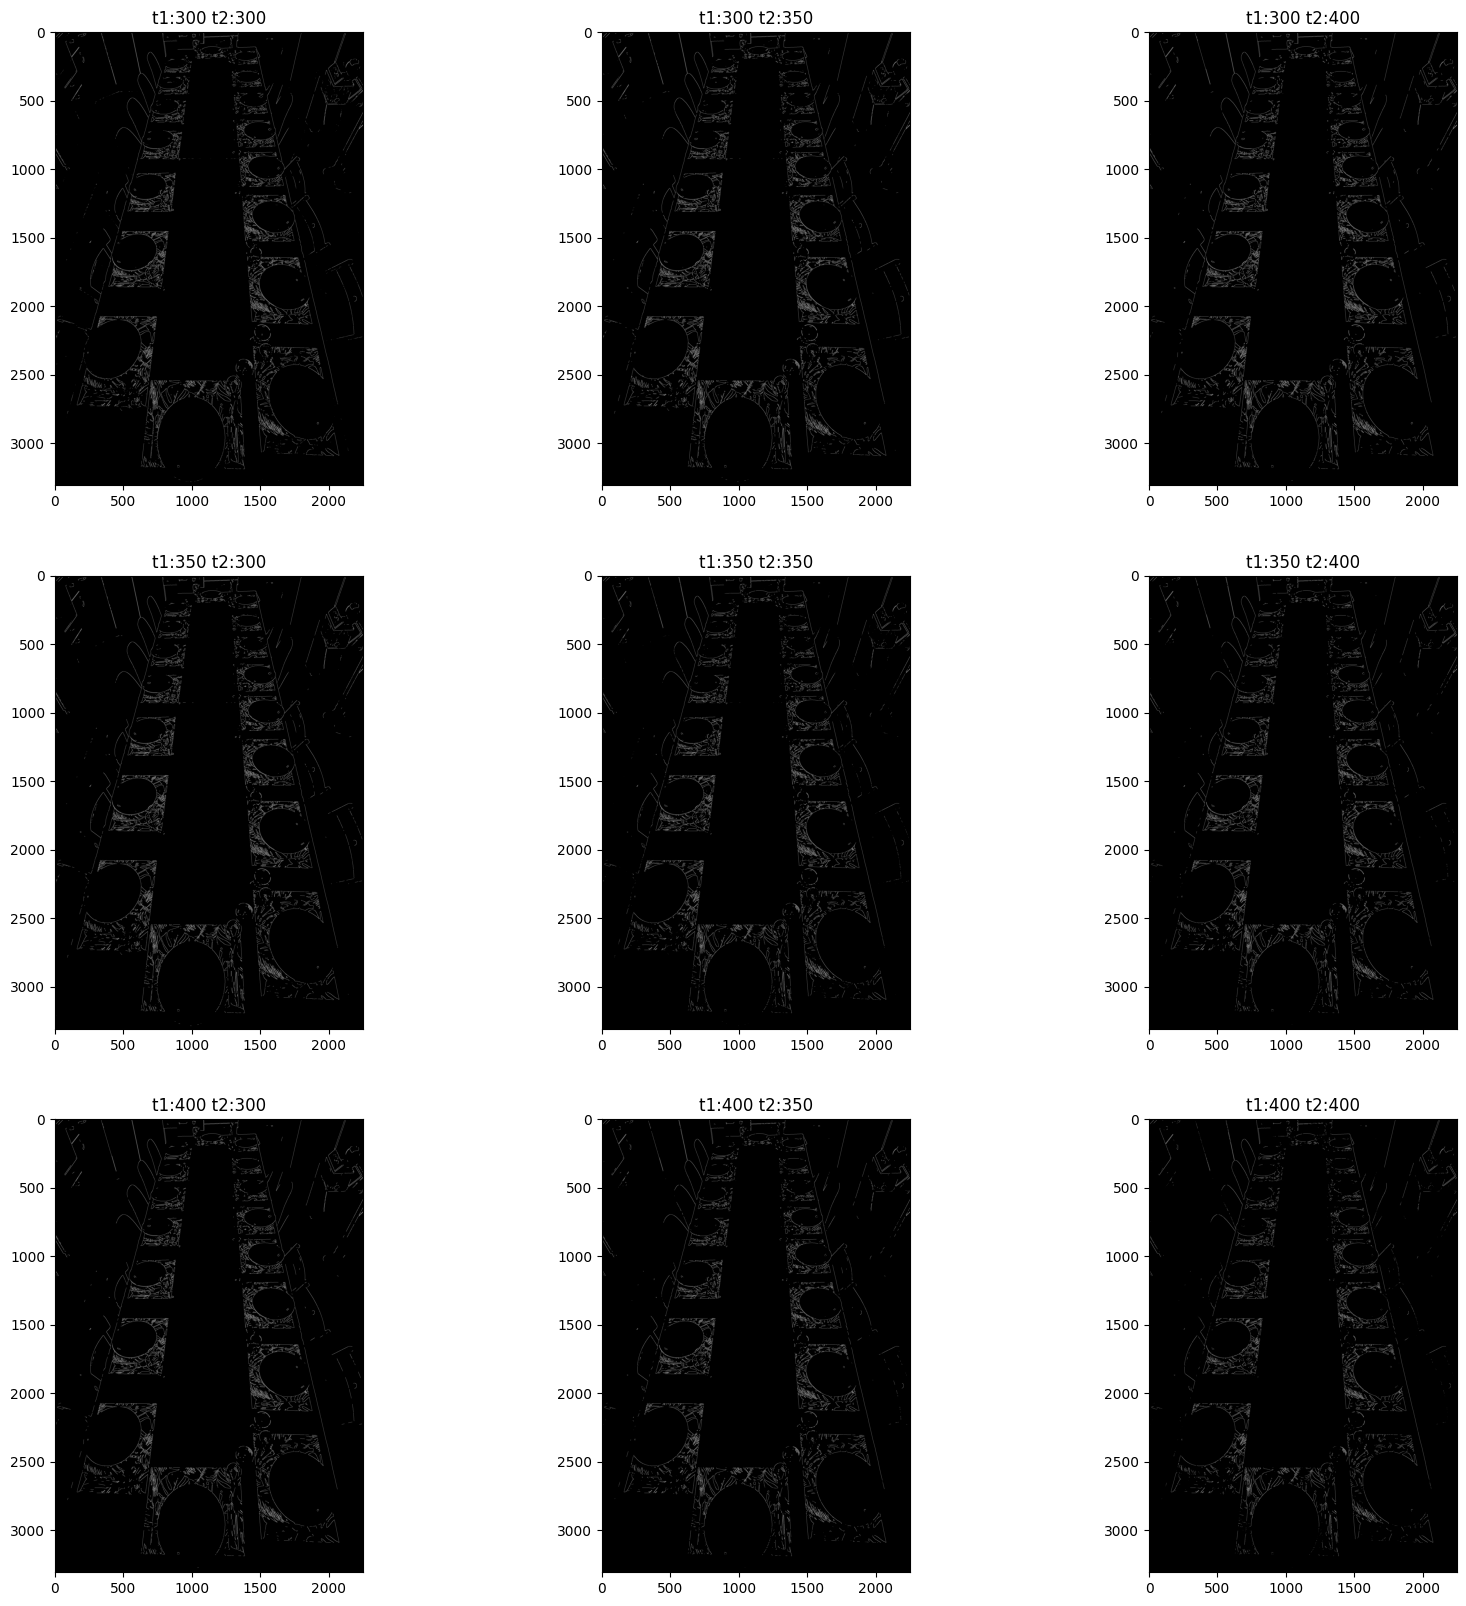

In [11]:
# comparing different params for canny's algorithm
t_low = 300
t_high = 450
size = len(range(t_low,t_high, 50))
_, axes = plt.subplots(size, size, figsize=(20, 20))
for ax, img ,title in zip(axes.flatten(),
                          [cv2.Canny(gray, t1, t2) for t1 in range(t_low, t_high, 50) for t2 in range(t_low, t_high, 50)],
                          [f"t1:{t1} t2:{t2}" for t1 in range(t_low, t_high, 50) for t2 in range(t_low, t_high, 50)]):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)

In [5]:
# gemini suggested code
import cv2

def detect_plates(image):
  # Convert image to grayscale for better color processing
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Apply adaptive thresholding to handle uneven lighting
  thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                 cv2.THRESH_BINARY_INV, 11, 2)

  # Find contours in the thresholded image
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Initialize variables
  plates = []

  # Loop through contours
  for cnt in contours:
    # Get contour area and approximate polygon
    area = cv2.contourArea(cnt)
    approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

    # Check if contour has 4 sides (rectangular) and minimum area
    if len(approx) == 4 and area > 1000:
      # Get bounding rectangle of the plate
      x, y, w, h = cv2.boundingRect(cnt)
      plates.append((x, y, w, h))
      # You can optionally draw the rectangle on the image here
      # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

  return len(plates), plates

# Example usage
image = cv2.imread("Images/table17verticalCropped.jpg")
num_plates, contours = detect_plates(image)

print(f"Number of plates detected: {num_plates}")

# Display the image with optional rectangle overlays (commented out)
# cv2.imshow("Plates", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


Number of plates detected: 3


In [9]:
#code from g4g simple blob detector
image = cv2.imread("Images/tableFor3cropped.jpg")
# Set our filtering parameters 
# Initialize parameter setting using cv2.SimpleBlobDetector 
params = cv2.SimpleBlobDetector_Params() 
  
# Set Area filtering parameters 
params.filterByArea = True
params.minArea = 1000
  
# Set Circularity filtering parameters 
params.filterByCircularity = True 
params.minCircularity = 0.7
  
# Set Convexity filtering parameters 
params.filterByConvexity = True
params.minConvexity = 0.2
      
# Set inertia filtering parameters 
params.filterByInertia = True
params.minInertiaRatio = 0.01
  
# Create a detector with the parameters 
detector = cv2.SimpleBlobDetector_create(params) 
      
# Detect blobs 
keypoints = detector.detect(image) 
  
# Draw blobs on our image as red circles 
blank = np.zeros((1, 1))  
blobs = cv2.drawKeypoints(image, keypoints, blank, (0, 0, 255), 
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
  
number_of_blobs = len(keypoints) 
text = "Number of Circular Blobs: " + str(len(keypoints)) 
cv2.putText(blobs, text, (20, 550), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 255), 2) 
  
# Show blobs 
cv2.imshow("Filtering Circular Blobs Only", blobs) 
cv2.waitKey(0) 
cv2.destroyAllWindows() 